In [ ]:
import copy
import os
from pathlib import Path
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from torchview import draw_graph
from torchvision import datasets, transforms
from torchvision.models import ResNet34_Weights, resnet34
from torchvision.utils import make_grid

In [30]:
DATA_ROOT = Path("datasets")
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = max(1, (os.cpu_count() or 1) // 2)

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

def create_dataloaders(data_root: Path,
                       batch_size: int = BATCH_SIZE,
                       img_size: int = IMG_SIZE,
                       num_workers: int = NUM_WORKERS):
    """Create ImageFolder datasets with augmentation-aware dataloaders."""
    data_root = Path(data_root)
    if not data_root.exists():
        raise FileNotFoundError(f"Dataset root not found: {data_root.resolve()}")

    train_transforms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomAffine(degrees=20, scale=(0.9, 1.1)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ])

    eval_transforms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ])

    datasets_map = {
        "train": datasets.ImageFolder(root=data_root / "train", transform=train_transforms),
        "val": datasets.ImageFolder(root=data_root / "val", transform=eval_transforms),
    }

    try:
        datasets_map["test"] = datasets.ImageFolder(root=data_root / "test", transform=eval_transforms)
    except (FileNotFoundError, ValueError):
        pass

    dataloaders = {
        split: DataLoader(ds,
                          batch_size=batch_size,
                          shuffle=(split == "train"),
                          num_workers=num_workers,
                          pin_memory=torch.cuda.is_available())
        for split, ds in datasets_map.items()
    }

    return dataloaders, datasets_map["train"].classes


dataloaders, class_names = create_dataloaders(DATA_ROOT)

for split, loader in dataloaders.items():
    print(f"{split}: {len(loader.dataset)} images across {len(class_names)} classes")

print(f"Classes: {class_names}")

train: 20000 images across 2 classes
val: 5000 images across 2 classes
Classes: ['cat', 'dog']


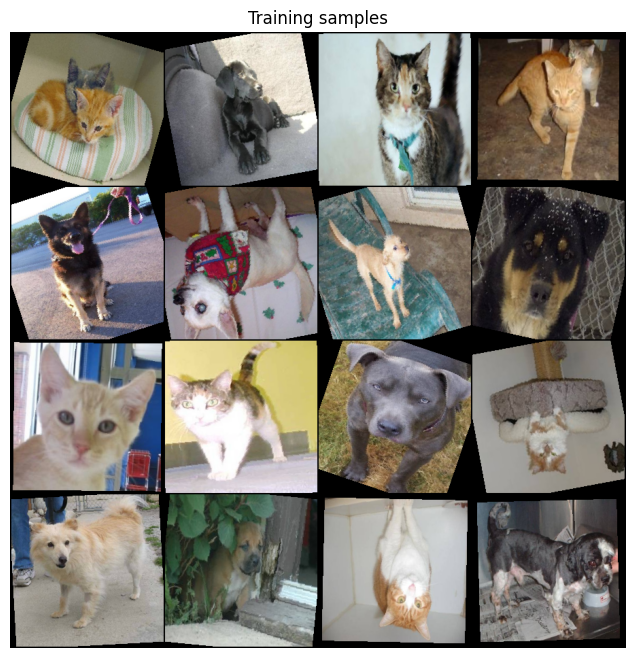

In [15]:
def visualize_batch(dataloader, n_images: int = 16, title: Optional[str] = None):
    """Display a grid of images from a dataloader batch."""
    if n_images < 1:
        raise ValueError("n_images must be at least 1")

    images, labels = next(iter(dataloader))
    n_images = min(n_images, images.size(0))
    images = images[:n_images].detach().cpu()

    mean = torch.tensor(IMAGENET_MEAN).view(-1, 1, 1)
    std = torch.tensor(IMAGENET_STD).view(-1, 1, 1)
    images = images * std + mean

    grid = make_grid(images, nrow=int(n_images**0.5) or 1, padding=2)
    np_img = grid.permute(1, 2, 0).numpy().clip(0, 1)

    plt.figure(figsize=(8, 8))
    plt.imshow(np_img)
    plt.axis("off")
    plt.title(title or "Sample batch")
    plt.show()


visualize_batch(dataloaders["train"], title="Training samples")

In [ ]:
def get_device() -> torch.device:
    if torch.cuda.is_available():
        return torch.device("cuda")
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")


def build_feature_extractor(num_classes: int) -> nn.Module:
    """Load a pretrained ResNet-50 and expose a trainable classifier head."""
    weights = ResNet34_Weights.IMAGENET1K_V1
    model = resnet34(weights=weights)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model


def train_one_epoch(model: nn.Module,
                    dataloader: DataLoader,
                    criterion: nn.Module,
                    optimizer: torch.optim.Optimizer,
                    device: torch.device,
                    epoch: int,
                    total_epochs: int) -> tuple[float, float]:
    model.train()
    running_loss = 0.0
    running_corrects = 0
    samples = 0

    for inputs, labels in tqdm(dataloader,
                               desc=f"Train [{epoch + 1}/{total_epochs}]",
                               leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += outputs.argmax(dim=1).eq(labels).sum().item()
        samples += inputs.size(0)

    return running_loss / samples, running_corrects / samples


def evaluate(model: nn.Module,
             dataloader: Optional[DataLoader],
             criterion: nn.Module,
             device: torch.device,
             split: str,
             epoch: Optional[int] = None,
             total_epochs: Optional[int] = None) -> tuple[float, float]:
    if dataloader is None:
        return float("nan"), float("nan")

    model.eval()
    running_loss = 0.0
    running_corrects = 0
    samples = 0

    if epoch is not None and total_epochs is not None:
        desc = f"{split.capitalize()} [{epoch + 1}/{total_epochs}]"
    else:
        desc = split.capitalize()

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc=desc, leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += outputs.argmax(dim=1).eq(labels).sum().item()
            samples += inputs.size(0)

    if samples == 0:
        return float("nan"), float("nan")

    return running_loss / samples, running_corrects / samples


def train_feature_extractor(dataloaders: dict,
                            num_classes: int,
                            epochs: int = EPOCHS,
                            lr: float = LEARNING_RATE) -> tuple[nn.Module, dict[str, list[float]]]:
    train_loader = dataloaders.get("train")
    val_loader = dataloaders.get("val")
    if train_loader is None or val_loader is None:
        raise ValueError("Both 'train' and 'val' splits are required for training.")

    device = get_device()
    print(f"Using device: {device}")

    model = build_feature_extractor(num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    scheduler = StepLR(optimizer, step_size=max(epochs // 2, 1), gamma=0.1) if epochs > 1 else None

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    best_weights = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0

    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, epochs)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device, split="val", epoch=epoch, total_epochs=epochs)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        if scheduler is not None:
            scheduler.step()

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_weights = copy.deepcopy(model.state_dict())

        print(f"Epoch {epoch + 1}/{epochs} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    model.load_state_dict(best_weights)
    print(f"Best validation accuracy: {best_val_acc:.4f}")

    test_loader = dataloaders.get("test")
    if test_loader is not None:
        test_loss, test_acc = evaluate(model, test_loader, criterion, device, split="test")
        print(f"Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}")

    return model, history


feature_model, training_history = train_feature_extractor(dataloaders,
                                                          num_classes=len(class_names),
                                                          epochs=EPOCHS,
                                                          lr=LEARNING_RATE)

Using device: mps


6.9%

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /Users/kevinjk/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100.0%
100.0%
                                                              

Epoch 1/5 | Train Loss: 0.1985 Acc: 0.9171 | Val Loss: 0.0691 Acc: 0.9772


Epoch 2/5 | Train Loss: 0.1555 Acc: 0.9355 | Val Loss: 0.0654 Acc: 0.9772


Epoch 3/5 | Train Loss: 0.1344 Acc: 0.9432 | Val Loss: 0.0619 Acc: 0.9776


Epoch 4/5 | Train Loss: 0.1297 Acc: 0.9478 | Val Loss: 0.0616 Acc: 0.9778


Epoch 5/5 | Train Loss: 0.1313 Acc: 0.9467 | Val Loss: 0.0629 Acc: 0.9778
Best validation accuracy: 0.9778


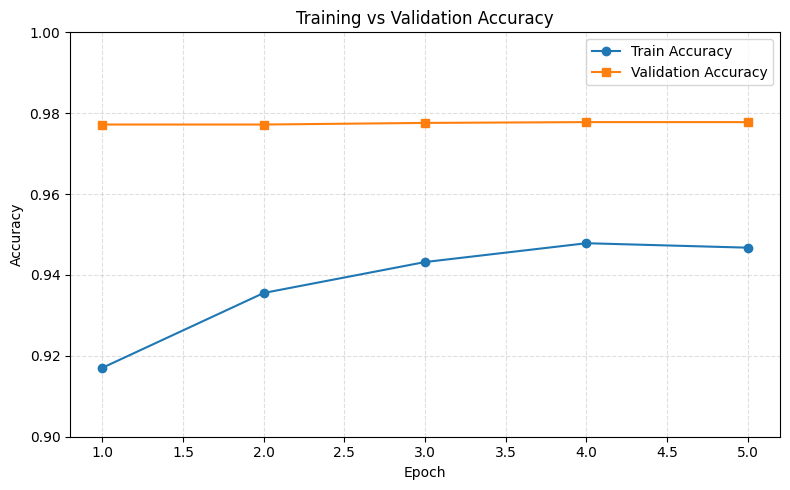

In [35]:
def plot_accuracy(history: dict[str, list[float]]):
    """Plot training and validation accuracy history."""
    epochs = range(1, len(history.get("train_acc", [])) + 1)
    if not epochs:
        raise ValueError("History is empty; run training before plotting.")

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history["train_acc"], label="Train Accuracy", marker="o")
    plt.plot(epochs, history["val_acc"], label="Validation Accuracy", marker="s")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.ylim(0.90, 1.0)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_accuracy(training_history)

In [ ]:
def unfreeze_last_blocks(model: nn.Module, num_blocks: int = 2) -> nn.Module:
    """Enable gradient updates for the last few residual blocks and classifier."""
    blocks = list(model.layer4.children())
    if num_blocks > len(blocks):
        raise ValueError(f"Requested {num_blocks} blocks but model.layer4 has only {len(blocks)}")

    for block in blocks[-num_blocks:]:
        for param in block.parameters():
            param.requires_grad = True

    for param in model.fc.parameters():
        param.requires_grad = True

    return model


def fine_tune_model(model: nn.Module,
                     dataloaders: dict,
                     epochs: int = 15,
                     lr: float = 1e-5,
                     num_blocks_to_unfreeze: int = 2) -> tuple[nn.Module, dict[str, list[float]]]:
    train_loader = dataloaders.get("train")
    val_loader = dataloaders.get("val")
    if train_loader is None or val_loader is None:
        raise ValueError("Both 'train' and 'val' splits are required for fine-tuning.")

    device = get_device()
    model = model.to(device)
    model = unfreeze_last_blocks(model, num_blocks=num_blocks_to_unfreeze)

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    scheduler = StepLR(optimizer, step_size=max(epochs // 3, 1), gamma=0.5) if epochs > 1 else None

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    best_weights = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0

    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, epochs)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device, split="val", epoch=epoch, total_epochs=epochs)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        if scheduler is not None:
            scheduler.step()

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_weights = copy.deepcopy(model.state_dict())

        print(f"[Fine-tune] Epoch {epoch + 1}/{epochs} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    model.load_state_dict(best_weights)
    print(f"Best validation accuracy after fine-tuning: {best_val_acc:.4f}")

    test_loader = dataloaders.get("test")
    if test_loader is not None:
        test_loss, test_acc = evaluate(model, test_loader, criterion, device, split="test")
        print(f"Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}")

    return model, history


feature_model, finetune_history = fine_tune_model(feature_model,
                                                  dataloaders,
                                                  epochs=15,
                                                  lr=1e-5,
                                                  num_blocks_to_unfreeze=2)


[Fine-tune] Epoch 1/15 | Train Loss: 0.1202 Acc: 0.9506 | Val Loss: 0.0477 Acc: 0.9836


[Fine-tune] Epoch 2/15 | Train Loss: 0.0993 Acc: 0.9600 | Val Loss: 0.0432 Acc: 0.9848


[Fine-tune] Epoch 3/15 | Train Loss: 0.0880 Acc: 0.9650 | Val Loss: 0.0406 Acc: 0.9868


[Fine-tune] Epoch 4/15 | Train Loss: 0.0790 Acc: 0.9679 | Val Loss: 0.0379 Acc: 0.9858


[Fine-tune] Epoch 5/15 | Train Loss: 0.0709 Acc: 0.9722 | Val Loss: 0.0392 Acc: 0.9852


[Fine-tune] Epoch 6/15 | Train Loss: 0.0640 Acc: 0.9758 | Val Loss: 0.0355 Acc: 0.9882


[Fine-tune] Epoch 7/15 | Train Loss: 0.0623 Acc: 0.9748 | Val Loss: 0.0361 Acc: 0.9874


[Fine-tune] Epoch 8/15 | Train Loss: 0.0573 Acc: 0.9779 | Val Loss: 0.0350 Acc: 0.9878


[Fine-tune] Epoch 9/15 | Train Loss: 0.0597 Acc: 0.9770 | Val Loss: 0.0360 Acc: 0.9880


[Fine-tune] Epoch 10/15 | Train Loss: 0.0578 Acc: 0.9761 | Val Loss: 0.0350 Acc: 0.9876


[Fine-tune] Epoch 11/15 | Train Loss: 0.0525 Acc: 0.9794 | Val Loss: 0.0353 Acc: 0.9874


[Fine-tune] Epoch 12/15 | Train Loss: 0.0532 Acc: 0.9798 | Val Loss: 0.0365 Acc: 0.9870


[Fine-tune] Epoch 13/15 | Train Loss: 0.0526 Acc: 0.9805 | Val Loss: 0.0358 Acc: 0.9874


[Fine-tune] Epoch 14/15 | Train Loss: 0.0489 Acc: 0.9817 | Val Loss: 0.0347 Acc: 0.9882


[Fine-tune] Epoch 15/15 | Train Loss: 0.0497 Acc: 0.9819 | Val Loss: 0.0343 Acc: 0.9886
Best validation accuracy after fine-tuning: 0.9886


In [40]:
artifacts_dir = Path("artifacts")
artifacts_dir.mkdir(parents=True, exist_ok=True)
weights_path = artifacts_dir / "resnet34_finetuned.pth"
torch.save(feature_model.state_dict(), weights_path)
print(f"Saved fine-tuned weights to {weights_path}")

Saved fine-tuned weights to artifacts/resnet34_finetuned.pth


Combined epochs: 20 (feature extraction: 5, fine-tuning: 15)


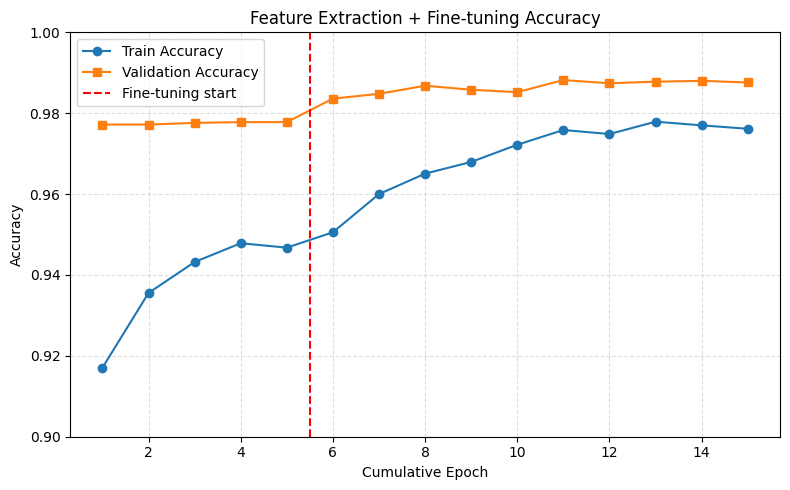

Feature extraction epochs: 1-5
Fine-tuning epochs: 6-15


TypeError: unhashable type: 'slice'

In [ ]:
def combine_histories(initial: dict[str, list[float]], continued: dict[str, list[float]]):
    """Concatenate metric histories from feature extraction and fine-tuning runs."""
    if not initial or not continued:
        raise ValueError("Both initial and continued histories must be provided.")

    combined = {metric: list(initial.get(metric, [])) + list(continued.get(metric, []))
                for metric in set(initial) | set(continued)}

    initial_epochs = len(initial.get("train_acc", []))
    continued_epochs = len(continued.get("train_acc", []))
    epoch_index = np.arange(1, initial_epochs + continued_epochs + 1)

    boundary_epoch = initial_epochs
    return combined, epoch_index, boundary_epoch


def plot_combined_accuracy(initial_history: dict[str, list[float]],
                            continued_history: dict[str, list[float]]):
    combined, epoch_index, boundary = combine_histories(initial_history, continued_history)
    epoch_index = epoch_index[:15]

    plt.figure(figsize=(8, 5))
    plt.plot(epoch_index, combined["train_acc"][:15], label="Train Accuracy", marker="o")
    plt.plot(epoch_index, combined["val_acc"][:15], label="Validation Accuracy", marker="s")
    plt.axvline(boundary + 0.5, color="red", linestyle="--", linewidth=1.5, label="Fine-tuning start")
    plt.xlabel("Cumulative Epoch")
    plt.ylabel("Accuracy")
    plt.title("Feature Extraction + Fine-tuning Accuracy")
    plt.ylim(0.90, 1.0)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Feature extraction epochs: 1-{boundary}")
    print(f"Fine-tuning epochs: {boundary + 1}-{len(epoch_index)}")


def plot_combined_loss(initial_history: dict[str, list[float]],
                       continued_history: dict[str, list[float]]):
    combined, epoch_index, boundary = combine_histories(initial_history, continued_history)
    combined = combined
    epoch_index = epoch_index[:15]
    
    plt.figure(figsize=(8, 5))
    plt.plot(epoch_index, combined["train_loss"][:15], label="Train Loss", marker="o")
    plt.plot(epoch_index, combined["val_loss"][:15], label="Validation Loss", marker="s")
    plt.axvline(boundary + 0.5, color="red", linestyle="--", linewidth=1.5, label="Fine-tuning start")
    plt.xlabel("Cumulative Epoch")
    plt.ylabel("Loss")
    plt.title("Feature Extraction + Fine-tuning Loss")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()


combined_history, combined_epochs, boundary_epoch = combine_histories(training_history, finetune_history)
print(f"Combined epochs: {len(combined_epochs)} (feature extraction: {boundary_epoch}, fine-tuning: {len(combined_epochs) - boundary_epoch})")
plot_combined_accuracy(training_history, finetune_history)
plot_combined_loss(training_history, finetune_history)